# 量價分析

1. 取出 當天 與 前三天的交易量
2. 判斷 量 是否 倍增

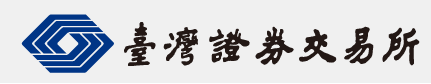

台灣證券交易所網站: https://www.twse.com.tw/zh/

程式參考網站:https://www.finlab.tw/Python-%E7%B0%A1%E5%96%AE158%E7%A8%AE%E6%8A%80%E8%A1%93%E6%8C%87%E6%A8%99%E8%A8%88%E7%AE%97/

讀取 30天 資料

## 只有上市 部分

In [ ]:
import requests
from io import StringIO
import pandas as pd
import numpy as np

def crawl_price(date):
    # 下載股價
    r = requests.post('http://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date=' + str(date).split(' ')[0].replace('-','') + '&type=ALL')
    
    # 整理資料，變成表格
    ret = pd.read_csv(StringIO("\n".join([i.translate({ord(c): None for c in ' '}) 
                                        for i in r.text.split('\n') 
                                        if len(i.split('",')) == 17 and i[0] != '='])), header=0)
    ret = ret.set_index('證券代號')
    ret['成交金額'] = ret['成交金額'].str.replace(',','')
    ret['成交股數'] = ret['成交股數'].str.replace(',','')
    return ret

呼叫每日爬蟲，連續爬 n 天
接下來我們就來利用這個 function 幫我們爬最近30天的資料，並將數據存在 data 這個 variable 中：

一次爬 n_days 天的股價

大部分的天數都是 success 代表成功讀取資料，但是每間隔5天就會顯示兩次 fail，代表那可能是假日，然而不能保證就是了，也可能是你的網路斷掉XD，或是 code 有bug，就要單獨做測試，至少在我的電腦裡，它抓的滿好的。

# 參數 設定

In [ ]:
#讀取 往前 天數資料  預設為 10 天
n_days = 5

In [ ]:
import datetime
import time

data = {}
date = datetime.datetime.now()
fail_count = 0
allow_continuous_fail_count = 5
while len(data) < n_days:

    print('parsing', date)
    # 使用 crawPrice 爬資料
    try:
        # 抓資料
        data[date.date()] = crawl_price(date)
        print('success!')
        fail_count = 0
    except:
        # 假日爬不到
        print('fail! check the date is holiday')
        fail_count += 1
        if fail_count == allow_continuous_fail_count:
            #raise
            break
    
    # 減一天
    date -= datetime.timedelta(days=1)
    time.sleep(10)

In [ ]:
data

整理 data 轉成 收盤價 time series
接下來我們來看一下得到了什麼：

In [ ]:
data[datetime.date(2020,8,17)]

In [ ]:
data[datetime.date(2020,8,17)]['本益比']

不同的日期，可以得到不同的表。但這並不是我們想要的，我們想要有 time series，也就是看到某個欄位隨時間變動的圖表，於是我們做以下的轉換：

在下面的程式中，現在我們只拿所有股票的 收盤價，並建構 close 這個 dataframe

In [ ]:
close = pd.DataFrame({k:d['收盤價'] for k,d in data.items()}).transpose()
close.index = pd.to_datetime(close.index)
close

In [ ]:
open = pd.DataFrame({k:d['開盤價'] for k,d in data.items()}).transpose()
open.index = pd.to_datetime(open.index)
open

In [ ]:
high = pd.DataFrame({k:d['最高價'] for k,d in data.items()}).transpose()
high.index = pd.to_datetime(high.index)
high

In [ ]:
low = pd.DataFrame({k:d['最低價'] for k,d in data.items()}).transpose()
low.index = pd.to_datetime(low.index)
low

In [ ]:
volume = pd.DataFrame({k:d['成交股數'] for k,d in data.items()}).transpose()
volume.index = pd.to_datetime(volume.index)
volume

open、high、low 跟 volume 統整好後，再將我們想看的股票拿出來，我們以近年超紅的台積電。

把其中的股票拿出來，變成 dict 結構

In [ ]:
tsmc = {
    'close':close['6412']['2020'].dropna().astype(float),
    'open':open['6412']['2020'].dropna().astype(float),
    'high':high['6412']['2020'].dropna().astype(float),
    'low':low['6412']['2020'].dropna().astype(float),
    'volume': volume['6412']['2020'].dropna().astype(float),
}

tsmc['close'].plot()

In [ ]:
volume['1101'][0]

In [ ]:
volume['1101'][1]

In [ ]:
volume.columns[0]

In [ ]:
volume.columns[1]

# 將資料寫入 csv 檔案

In [ ]:
#用to_csv存檔，並命名為 "股票代號.csv"
#df.to_csv(sid+'.csv')

(base) C:\Users\duchu>pip install TA_Lib-0.4.18-cp37-cp37m-win_amd64.whl

# KD 值計算

橘色、藍色代表的就是KD值。而紫色的就是收盤價！

In [ ]:
# 參考
#分別 計算 K 和 D 值
K,D = talib.STOCH(high, 
                  low, 
                  close,
                  fastk_period=9,
                  slowk_period=3,
                  slowk_matype=0,
                  slowd_period=3,
                  slowd_matype=0)

slowk, slowd = ta.STOCH(high,low,close, fastk_period=9, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    slowkMA5 = ta.MA(slowk, timeperiod=5, matype=0)
    slowkMA10 = ta.MA(slowk, timeperiod=10, matype=0)
    slowkMA20 = ta.MA(slowk, timeperiod=20, matype=0)
    slowdMA5 = ta.MA(slowd, timeperiod=5, matype=0)
    slowdMA10 = ta.MA(slowd, timeperiod=10, matype=0)
    slowdMA20 = ta.MA(slowd, timeperiod=20, matype=0)

In [ ]:
from talib import abstract
import talib

In [ ]:
def talib2df(talib_output):
    if type(talib_output) == list:
        ret = pd.DataFrame(talib_output).transpose()
    else:
        ret = pd.Series(talib_output)
    ret.index = tsmc['close'].index
    return ret;

#利用 talib.abstract.STOCH 這個函式，來計算KD值，計算好後，再由talib2df將格式轉換成 dataframe 方便我們畫圖
talib2df(abstract.STOCH(tsmc)).plot()

#我們想要同時顯示tsmc的收盤價，secondary_y 是說我們需要用第二個 y軸，因為KD我們知道是在0～100之間，而台積電股價在200左右
tsmc['close'].plot(secondary_y=True)

# MACD 計算

In [ ]:
talib2df(abstract.MACD(tsmc)).plot()
tsmc['close'].plot(secondary_y=True)

# OBV計算

In [ ]:
talib2df(abstract.OBV(tsmc)).plot()
tsmc['close'].plot(secondary_y=True)

# WILLR 計算

In [ ]:
talib2df(abstract.WILLR(tsmc)).plot()
tsmc['close'].plot(secondary_y=True)

# ATR 計算

In [ ]:
talib2df(abstract.ATR(tsmc)).plot()
tsmc['close'].plot(secondary_y=True)

這些就是可以用的指標，總共有158種，慢慢看，學也學不完XDD。

In [ ]:
talib.get_functions()